In [1]:
# load data

# using GTI_Right as testing for vehicles, and last 20% of GTI for nonvehicles

import glob
import os

cars = []
notcars = []

def load_images_from_dir(parent_dir, l):
    for sub_dir in os.listdir(parent_dir):
        if os.path.isdir(os.path.join(parent_dir, sub_dir)):
            images = glob.glob(os.path.join(parent_dir, sub_dir, '*.PNG'))
            for image in images:
                l.append(image)

vehicles_dir = "C:\\Users\\AW51R2\\code\\carnd\\CarND-Vehicle-Detection\\vehicles\\vehicles"
non_vehicles_dir = "C:\\Users\\AW51R2\\code\\carnd\\CarND-Vehicle-Detection\\non-vehicles\\non-vehicles"


load_images_from_dir(vehicles_dir, cars)
load_images_from_dir(non_vehicles_dir, notcars)

print("cars: ", len(cars))
print("notcars: ", len(notcars))


cars:  8792
notcars:  8968


In [2]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

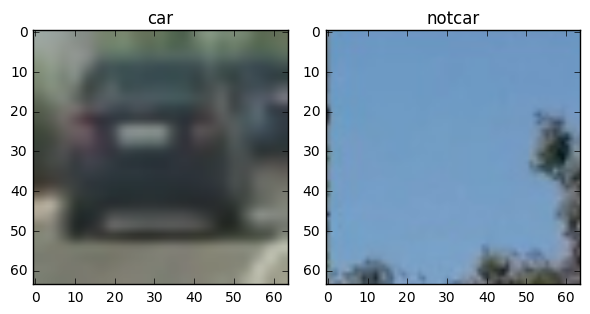

In [5]:
# example of car and notcar
%matplotlib inline
sample_car_img = cv2.cvtColor(cv2.imread(cars[0]), cv2.COLOR_BGR2RGB)
sample_notcar_img = cv2.cvtColor(cv2.imread(notcars[0]), cv2.COLOR_BGR2RGB)

sample_img_fig = plt.figure()
plt.subplot(121)
plt.imshow(sample_car_img)
plt.title('car')
plt.subplot(122)
plt.imshow(sample_notcar_img)
plt.title('notcar')
sample_img_fig.tight_layout()
plt.show()


In [6]:
#hog feature
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    


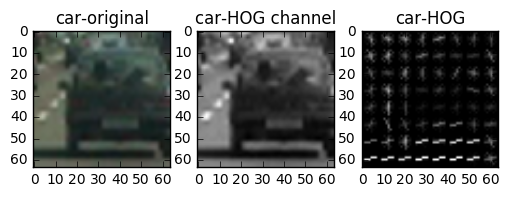

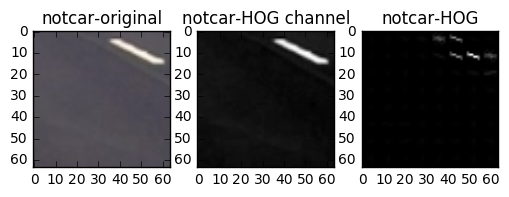

In [14]:
#example using hog feature
%matplotlib inline

orient = 9
pix_per_cell = 8
cell_per_block = 2

ind = np.random.randint(0, len(cars))

car_image = cv2.cvtColor(cv2.imread(cars[ind]), cv2.COLOR_BGR2RGB)
notcar_image = cv2.cvtColor(cv2.imread(notcars[ind]), cv2.COLOR_BGR2RGB)

car_gray = cv2.cvtColor(car_image,cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar_image,cv2.COLOR_RGB2GRAY)

_, car_hog_image = get_hog_features(car_gray, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)
_, notcar_hog_image = get_hog_features(notcar_gray, orient, pix_per_cell, cell_per_block,vis=True, feature_vec=False)

fig = plt.figure(0)
plt.subplot(131)
plt.imshow(car_image)
plt.title('car-original')
plt.subplot(132)
plt.imshow(car_gray, cmap='gray')
plt.title('car-HOG channel')
plt.subplot(133)
plt.imshow(car_hog_image, cmap='gray')
plt.title('car-HOG')
plt.show()

fig = plt.figure(1)
plt.subplot(131)
plt.imshow(notcar_image)
plt.title('notcar-original')
plt.subplot(132)
plt.imshow(notcar_gray, cmap='gray')
plt.title('notcar-HOG channel')
plt.subplot(133)
plt.imshow(notcar_hog_image, cmap='gray')
plt.title('notcar-HOG')
plt.show()

In [15]:
#color and spatial functions  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [17]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        file_features = extract_features_image(image, spatial_size,
                                              hist_bins, orient,
                                              pix_per_cell,cell_per_block,
                                              spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    return features

def extract_features_image(image, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # image is BGR, [0,255]
    file_features = []
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # [0,255]
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if spatial_feat == True:
        spatial_features = bin_spatial(image, size=spatial_size)
        file_features.append(spatial_features)

    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(image, nbins=hist_bins)
        file_features.append(hist_features)

    if hog_feat == True: # we know it's gray
        hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)    
        file_features.append(hog_features)
    return np.concatenate(file_features)
    


In [19]:
#parameters
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars,  
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("done!")


done!


In [20]:
# train SVC
# Split up data into randomized training and test sets
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score

rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
scores = cross_val_score(svc, scaled_X, y, cv=5)
t2 = time.time()
svc.fit(X_train, y_train)
print(round(t2-t, 2), 'Seconds to train SVC...')
print("scores:", scores)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
28.06 Seconds to train SVC...
scores: [ 0.93751759  0.92288207  0.97635135  0.97071248  0.95128133]
Test Accuracy of SVC =  0.9764


In [21]:
# save model
from sklearn.externals import joblib
# now you can save it to a file
joblib.dump(svc, 'svc.pkl') 

['svc.pkl']

In [22]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [25]:
# NOTE: this is only used for demo
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


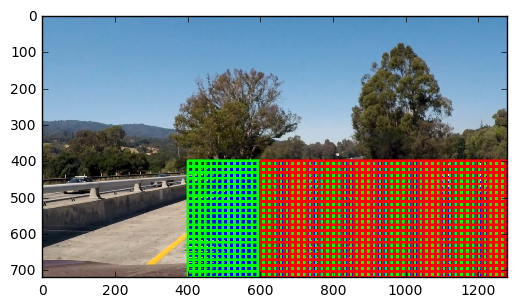

In [26]:
# demonstrate my window search strategy
#[(400,800,400,1.25),(400,800,400,1.5),(400,800,600,2)]
test_image = cv2.imread('test_images/test1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

bbox1 = slide_window(test_image, x_start_stop=[400,None],y_start_stop=[400,800],xy_window=(80,80), xy_overlap=(0.8,0.8))
bbox2 = slide_window(test_image, x_start_stop=[400,None],y_start_stop=[400,800],xy_window=(96,96), xy_overlap=(0.83,0.83))
bbox3 = slide_window(test_image, x_start_stop=[600,None],y_start_stop=[400,800],xy_window=(128,128), xy_overlap=(0.875,0.875))

test_image = draw_boxes(test_image, bbox1, color=(0, 0, 255), thick=6)
test_image = draw_boxes(test_image, bbox2, color=(0, 255, 0), thick=6)
test_image = draw_boxes(test_image, bbox3, color=(255, 0, 0), thick=6)

plt.imshow(test_image)


In [27]:
%load_ext autoreload
%aimport hog_parallel
%autoreload 1

In [28]:
from multiprocessing import Pool
pool = Pool(12)

In [29]:
from functools import partial
import hog_parallel

def find_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # img is BGR
    # color and spatial uses RGB
    # HOG uses gray
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    
    fs = []
    nblocks_per_window = (window // pix_per_cell)-1
    
    img_tosearch = img[ystart:ystop,xstart:,:]
    img_tosearch_copy = np.copy(img_tosearch)

    ctrans_tosearch = cv2.cvtColor(img_tosearch,cv2.COLOR_BGR2GRAY) # for HOG
    img_to_search_RGB = cv2.cvtColor(img_tosearch_copy, cv2.COLOR_BGR2RGB) # for color and spatial features

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_to_search_RGB = cv2.resize(img_to_search_RGB, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    t = time.time()
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            fs.append((xpos, ypos, 0))

    #print("total windows:", len(fs))
        
    #print("time for computing hog feature:", time.time() - t)
    
    bboxes = []
    
    t = time.time()
    
    N = pool.map(partial(hog_parallel.get_hog_feature_parallel, hogs = [hog1], nblocks_per_window = nblocks_per_window), fs) 
    
    #print("get all hog features takes:", time.time() - t)
                       
    t = time.time()
    
    for idx, hog_features in enumerate(N):
        
        (xpos, ypos, iidx) = fs[idx]
        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell
        
        # Extract the image patch
        subimg = cv2.resize(img_to_search_RGB[ytop:ytop+window, xleft:xleft+window], (64,64))

        # Get color features
        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
        test_prediction = svc.decision_function(test_features)

        if test_prediction >= 2:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bbox = ((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart))
            
            bboxes.append(bbox)        
    
    
    return bboxes

test_images/test1.jpg


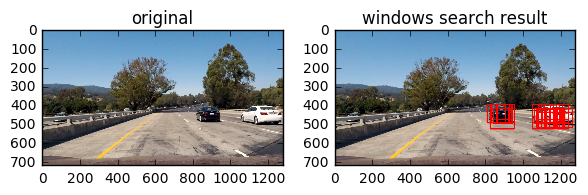

test_images/test3.jpg


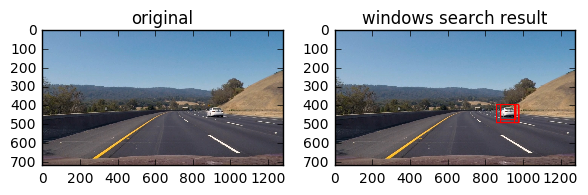

test_images/test4.jpg


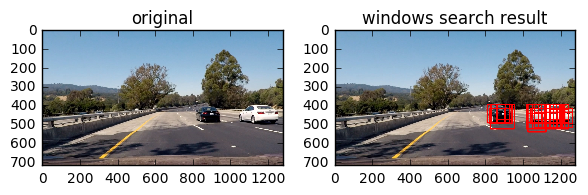

In [33]:
# example of windows search
for idx, fname in enumerate(['test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg']):
    print(fname)
    image = cv2.imread(fname) #test is read as BGR
    draw_image = np.copy(image)
    bboxes = []
    
    for (ystart,ystop,xstart,scale) in [(400,800,400,1.25),(400,800,400,1.5),(400,800,600,2)]:    
        bboxes_scale = find_cars(image, 
                           ystart, ystop, 
                           xstart, scale, 
                           svc, 
                           X_scaler, 
                           orient, pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
        bboxes += bboxes_scale

    for bbox in bboxes:
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    
    #convert back to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(idx+1)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('original')
    plt.subplot(122)
    plt.imshow(draw_image)
    plt.title('windows search result')
    fig.tight_layout()
    plt.show()

In [34]:
# heatmaps
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if np.max(nonzerox) - np.min(nonzerox) <= 32:
            print("x too narrow!")
        elif np.max(nonzeroy) - np.min(nonzeroy) <= 32:
            print("y too narrow!")
        elif np.max(nonzerox) <= 700:
            print("x too left!")
        else:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            bboxes.append(bbox)
    # Return the image
    return img, bboxes

In [35]:
def process_image(image):
    # assuming input is always BGR
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    draw_image = np.copy(image)
    multi_bbox_img = np.copy(image)
    
    bboxes = []
    
    for (ystart, ystop, xstart, scale) in [(400,800,400,1.25),(400,800,400,1.5),(400,800,600,2)]:
        bboxes_per_scale = find_cars(image, ystart, ystop, xstart, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes += bboxes_per_scale
    
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # image without heatmap
    window_img = draw_boxes(draw_image, bboxes, color=(0, 0, 255), thick=6)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, final_bboxes = draw_labeled_bboxes(np.copy(image), labels)
    
    #back to RGB for display only
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    
    for bbox in bboxes:
        cv2.rectangle(multi_bbox_img,bbox[0],bbox[1],(0,0,255),6) 
    
    # convert back to RGB
    multi_bbox_img = cv2.cvtColor(multi_bbox_img, cv2.COLOR_BGR2RGB)
    
    return draw_img, final_bboxes, bboxes
    #return multi_bbox_img, final_bboxes, bboxes

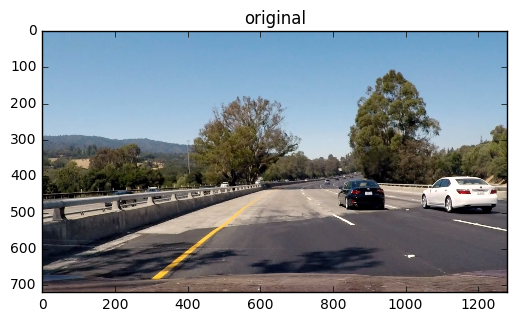

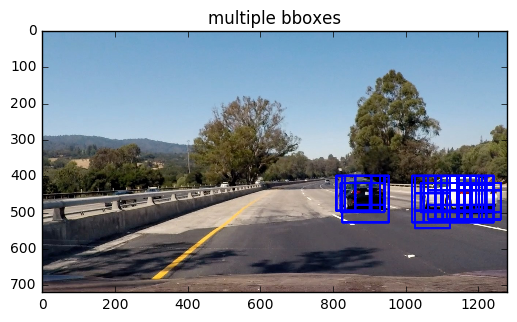

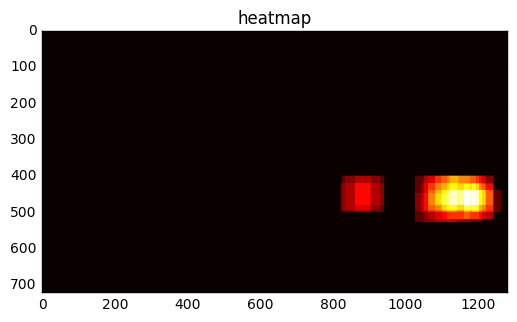

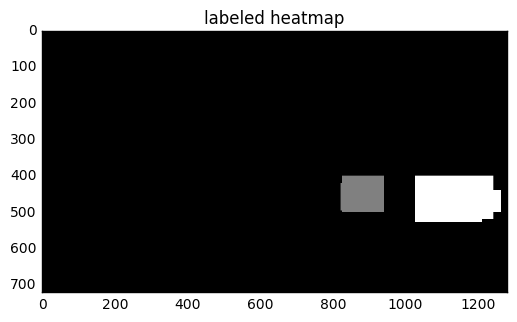

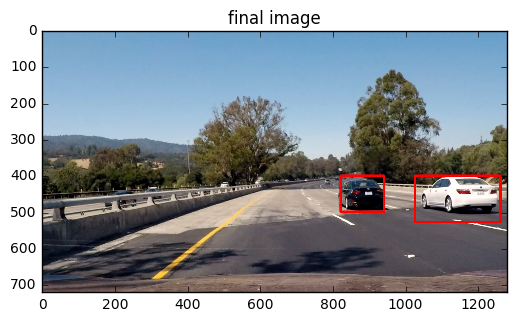

In [51]:
#single frame pipeline demonstration
test_image = cv2.imread('test_images/test4.jpg')
test_image_RGB = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

fig = plt.figure()
plt.imshow(test_image_RGB)
plt.title('original')
plt.show()

# get all bboxes
test_image_bboxes = np.copy(test_image_RGB)
bboxes = []

for (ystart,ystop,xstart,scale) in [(400,800,400,1.25),(400,800,400,1.5),(400,800,600,2)]:    
    bboxes_scale = find_cars(test_image, 
                       ystart, ystop, 
                       xstart, scale, 
                       svc, 
                       X_scaler, 
                       orient, pix_per_cell, cell_per_block, 
                       spatial_size, hist_bins)
    bboxes += bboxes_scale

for bbox in bboxes:
    cv2.rectangle(test_image_bboxes, bbox[0], bbox[1], (0,0,255), 6)
fig = plt.figure(1)
plt.imshow(test_image_bboxes)
plt.title('multiple bboxes')
plt.show()

# heatmap
test_heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
test_heat = add_heat(test_heat,bboxes)
test_heat = apply_threshold(test_heat,1)
test_heatmap = np.clip(test_heat, 0, 255)

fig = plt.figure(2)
plt.imshow(test_heatmap,cmap=plt.cm.hot)
plt.title('heatmap')
plt.show()

# label
test_labels = label(test_heatmap)

fig = plt.figure(3)
plt.imshow(test_labels[0], cmap='gray')
plt.title('labeled heatmap')
plt.show()

# final bbox
test_draw_img, _ = draw_labeled_bboxes(np.copy(test_image), test_labels)
test_draw_img = cv2.cvtColor(test_draw_img, cv2.COLOR_BGR2RGB)

fig = plt.figure(4)
plt.imshow(test_draw_img)
plt.title('final image')
plt.show()


In [ ]:
t=time.time()
n_predict = 20
#print('My SVC predicts: ', svc.predict_proba(X_test[0:n_predict]))
prd = svc.decision_function(X_test[0:n_predict])
print(prd)
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
from sklearn.externals import joblib
# load model
# and later you can load it
svc = joblib.load('svc.pkl')

In [ ]:
images = glob.glob('test_images/*.jpg')
#images = glob.glob('output_sequence/input_*.jpg')

for idx, fname in enumerate(images[3:4]):
    print(fname)
    image = cv2.imread(fname) #test is read as BGR
    draw_image = np.copy(image)
    bboxes = []
    
    for scale in [1,2]:    
        _, bboxes_scale = find_cars(image, 
                           ystart, ystop, 
                           scale, 
                           svc, 
                           X_scaler, 
                           orient, pix_per_cell, cell_per_block, 
                           spatial_size, hist_bins)
        bboxes += bboxes_scale

    for bbox in bboxes:
        cv2.rectangle(draw_image, bbox[0], bbox[1], (0,0,255), 6)
    
    fig = plt.figure(idx+1)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('bboxes')
    plt.subplot(122)
    plt.imshow(draw_image)
    plt.title('labeled box')
    fig.tight_layout()
    plt.show()

In [ ]:
images = glob.glob('test_images/*.jpg')
#images = glob.glob('output_sequence/input_*.jpg')

for idx, fname in enumerate(images):
    t=time.time()
    print(fname)
    image = cv2.imread(fname) #test is read as BGR
    draw_image, _, _ = process_image(image)
    print("elapsed:", round((time.time() - t),2))
    
    fig = plt.figure(idx+1)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('original BGR')
    plt.subplot(122)
    plt.imshow(draw_image)
    plt.title('labeled image')
    fig.tight_layout()
    plt.show()

In [ ]:
# cross-image heatmap
images = glob.glob('output_sequence/*.jpg')

from collections import deque
q = deque() # keep 5 frames of final_bboxes

for idx, fname in enumerate(images):
    print(fname)
    image = cv2.imread(fname) #test is read as BGR
    _, _, bboxes_without_heap = process_image(image)
    print("bbox per image:", bboxes_without_heap)
    
    # cross image heatmap
    q.append(bboxes_without_heap)
    if len(q) > 5:
        q.popleft()
    # flatten
    ql = [item for sublist in q for item in sublist]
    print("queue:", ql)
    # heat again
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,ql)
    heat = apply_threshold(heat,1)
    
    heat_std = heat.std(ddof=1)
    if heat_std != 0.0:
        heat = (heat-heat.mean())/heat_std
    heat = apply_threshold(heat, np.max([heat.std(), 1]))
    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img, avg_bboxes = draw_labeled_bboxes(np.copy(image), labels)
    print("avg bboxes:", avg_bboxes)
    
    #back to RGB for display only
    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    
    
    
    fig = plt.figure(idx+1)
    plt.subplot(121)
    plt.imshow(image)
    plt.title('original BGR')
    plt.subplot(122)
    plt.imshow(draw_img)
    plt.title('labeled image')
    fig.tight_layout()
    plt.show()

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
from collections import deque
q = deque()
avg_size = 7

cross_avg = True
count = 0

def video_process_image(image):
    global q
    global cross_avg
    global count
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    if cross_avg:
        _, final_bboxes_per_frame, _ = process_image(image)
        #print("bbox per image:", bboxes_without_heap)

        # cross image heatmap
        q.append(final_bboxes_per_frame)
        if len(q) > avg_size:
            q.popleft()
        # flatten
        ql = [item for sublist in q for item in sublist]
        #print("queue:", ql)
        # heat again
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat,ql)
        heat = apply_threshold(heat,1)
        
        # normalize
        #heat_std = heat.std(ddof=1)
        #if heat_std != 0.0:
        #    heat = (heat-heat.mean())/heat_std
        #heat = apply_threshold(heat, np.max([heat.std(), 1]))
        
        
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img, avg_bboxes = draw_labeled_bboxes(np.copy(image), labels)
        #print("avg bboxes:", avg_bboxes)

        #back to RGB for display only
        draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
                
        #cv2.imwrite("output_sequence_all_2/input_" + str(count) + ".jpg", image)
        #cv2.imwrite("output_sequence_all_2/output" + str(count) + ".jpg", draw_img)
        count += 1

        return draw_img
    
    else:
        draw_img, _, _ = process_image(image)
        return draw_img

In [ ]:
%matplotlib inline
clip1 = VideoFileClip('project_video.mp4', audio=False)
frame = clip1.get_frame(28) # this is RGB
img = video_process_image(frame)
plt.imshow(img)

In [ ]:
%matplotlib inline
output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4', audio=False)#.subclip(46,50)
white_clip = clip1.fl_image(video_process_image)
white_clip.write_videofile(output, audio = False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [ ]:
pool.close()